## Wczytanie danych

In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# GPU operations have a separate seed we also want to set
if torch.cuda.is_available(): 
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    
# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

dataset = torchvision.datasets.ImageFolder("./SSNE_25L/Z4/trafic_32", transform=transform)

train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size]
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    drop_last=True,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=128, shuffle=False, drop_last=False
)


def get_train_images(num):
    return torch.stack([test_dataset[i][0] for i in range(10, 10 + num)], dim=0)

Liczba klas: 43
Liczba obrazów w zbiorze treningowym: 35288
Liczba obrazów w zbiorze testowym: 3921


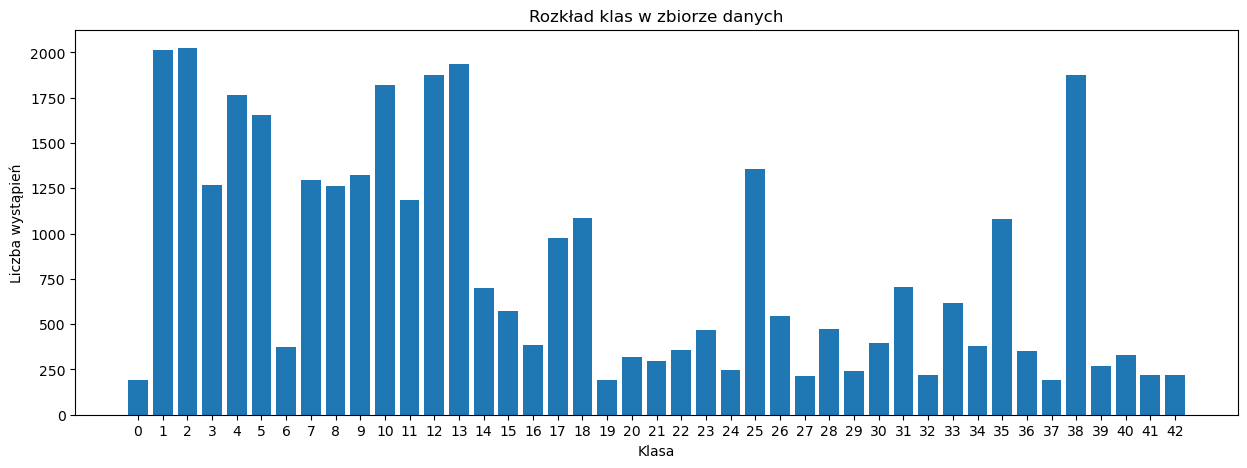

In [7]:
# Liczba wystąpień klas
def count_classes(dataset):
    counts = {}
    for _, label in dataset:
        if label not in counts:
            counts[label] = 0
        counts[label] += 1
    return counts

# Wyświetlenie liczby wystąpień klas
def plot_class_distribution(dataset):
    plt.figure(figsize=(15, 5))
    counts = count_classes(dataset)
    classes = list(counts.keys())
    values = list(counts.values())

    plt.bar(classes, values)
    plt.xlabel("Klasa")
    plt.ylabel("Liczba wystąpień")
    plt.title("Rozkład klas w zbiorze danych")
    plt.xticks(classes)
    plt.show()

print("Liczba klas:", len(dataset.classes))
print("Liczba obrazów w zbiorze treningowym:", len(train_dataset))
print("Liczba obrazów w zbiorze testowym:", len(test_dataset))

plot_class_distribution(train_dataset)

Input shape: torch.Size([8, 3, 32, 32])


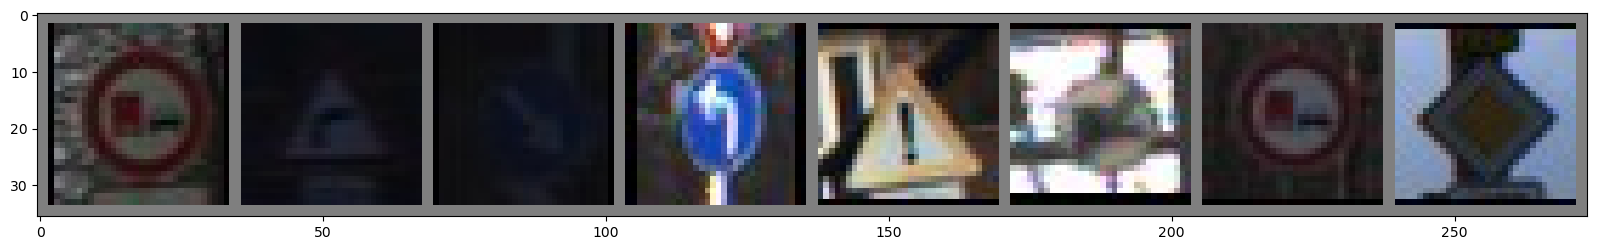

In [8]:
x, y = next(iter(train_loader))
x = x[:8]
print('Input shape:', x.shape)

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

plt.figure(figsize = (20,10))
imshow(torchvision.utils.make_grid(x))


## Model dyfuzyjny

In [9]:
def corrupt(x, amount):
    """Corrupt the input `x` by mixing it with noise according to `amount`"""
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
    return x*(1-amount) + noise*amount

In [10]:
import math

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = t[:, None] * emb[None, :]
        return torch.cat((emb.sin(), emb.cos()), dim=-1)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, use_conv_shortcut=False):
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, out_channels)
        )
        self.block1 = nn.Sequential(
            nn.GroupNorm(1, in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, 3, padding=1)
        )
        self.block2 = nn.Sequential(
            nn.GroupNorm(1, out_channels),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1)
        )
        self.res_conv = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, t):
        h = self.block1(x)
        h += self.time_mlp(t)[:, :, None, None]
        h = self.block2(h)
        return h + self.res_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, base_channels=64):
        super().__init__()
        time_emb_dim = base_channels * 4

        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(base_channels),
            nn.Linear(base_channels, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )

        # Down
        self.conv0 = ResidualBlock(in_channels, base_channels, time_emb_dim)
        self.down1 = ResidualBlock(base_channels, base_channels * 2, time_emb_dim)
        self.down2 = ResidualBlock(base_channels * 2, base_channels * 4, time_emb_dim)
        self.down3 = ResidualBlock(base_channels * 4, base_channels * 8, time_emb_dim)

        self.pool = nn.MaxPool2d(2)

        # Bottleneck
        self.bot = ResidualBlock(base_channels * 8, base_channels * 8, time_emb_dim)

        # Up
        self.up3 = ResidualBlock(base_channels * 16, base_channels * 4, time_emb_dim)
        self.up2 = ResidualBlock(base_channels * 8, base_channels * 2, time_emb_dim)
        self.up1 = ResidualBlock(base_channels * 4, base_channels, time_emb_dim)
        self.up0 = ResidualBlock(base_channels * 2, base_channels, time_emb_dim)

        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

        self.final_conv = nn.Sequential(
            nn.GroupNorm(1, base_channels),
            nn.SiLU(),
            nn.Conv2d(base_channels, out_channels, 1)
        )

    def forward(self, x, t):
        t = self.time_mlp(t)

        x0 = self.conv0(x, t)
        x1 = self.down1(self.pool(x0), t)
        x2 = self.down2(self.pool(x1), t)
        x3 = self.down3(self.pool(x2), t)

        x_bot = self.bot(self.pool(x3), t)

        u3 = self.up3(torch.cat([self.upsample(x_bot), x3], dim=1), t)
        u2 = self.up2(torch.cat([self.upsample(u3), x2], dim=1), t)
        u1 = self.up1(torch.cat([self.upsample(u2), x1], dim=1), t)
        u0 = self.up0(torch.cat([self.upsample(u1), x0], dim=1), t)

        return self.final_conv(u0)

In [9]:
net = UNet().to(device)
net

UNet(
  (time_mlp): Sequential(
    (0): SinusoidalPosEmb()
    (1): Linear(in_features=64, out_features=256, bias=True)
    (2): SiLU()
    (3): Linear(in_features=256, out_features=256, bias=True)
  )
  (conv0): ResidualBlock(
    (time_mlp): Sequential(
      (0): SiLU()
      (1): Linear(in_features=256, out_features=64, bias=True)
    )
    (block1): Sequential(
      (0): GroupNorm(1, 3, eps=1e-05, affine=True)
      (1): SiLU()
      (2): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (block2): Sequential(
      (0): GroupNorm(1, 64, eps=1e-05, affine=True)
      (1): SiLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (res_conv): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (down1): ResidualBlock(
    (time_mlp): Sequential(
      (0): SiLU()
      (1): Linear(in_features=256, out_features=128, bias=True)
    )
    (block1): Sequential(
      (0): GroupNorm(1, 64, eps=1e-05, affine=True)
      (1): 

In [10]:
sum([p.numel() for p in net.parameters()])

14515657

In [11]:
loss_fn = nn.MSELoss()

opt = torch.optim.Adam(net.parameters(), lr=1e-3)

Finished epoch 0. Average loss for this epoch: 0.084275
Finished epoch 1. Average loss for this epoch: 0.047094
Finished epoch 2. Average loss for this epoch: 0.044231
Finished epoch 3. Average loss for this epoch: 0.035978
Finished epoch 4. Average loss for this epoch: 0.035244
Finished epoch 5. Average loss for this epoch: 0.031311
Finished epoch 6. Average loss for this epoch: 0.029759
Finished epoch 7. Average loss for this epoch: 0.029801
Finished epoch 8. Average loss for this epoch: 0.027214
Finished epoch 9. Average loss for this epoch: 0.026784
Finished epoch 10. Average loss for this epoch: 0.026686
Finished epoch 11. Average loss for this epoch: 0.025086
Finished epoch 12. Average loss for this epoch: 0.026147
Finished epoch 13. Average loss for this epoch: 0.023631
Finished epoch 14. Average loss for this epoch: 0.022970
Finished epoch 15. Average loss for this epoch: 0.023979
Finished epoch 16. Average loss for this epoch: 0.023652
Finished epoch 17. Average loss for this 

(0.0, 0.1)

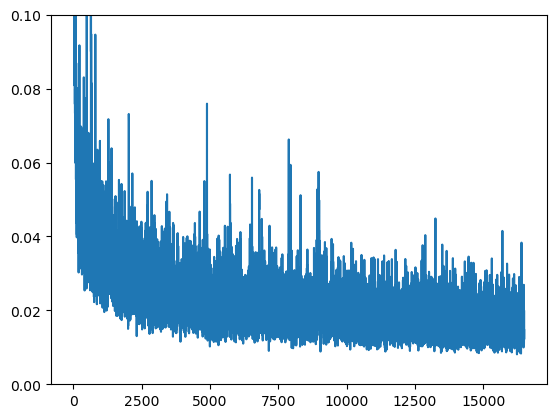

In [12]:
n_epochs = 60
losses = []

for epoch in range(n_epochs):
    for x, y in train_loader:
        x = x.to(device)

        # Losowanie ilości dodanego szumu - może być krok, albo jak w tym przypadku ciągła wartość w %
        noise_amount = torch.rand(x.shape[0]).to(device) 
        noisy_x = corrupt(x, noise_amount) 

        # Predykcja oryginalnego - czystego obrazka
        pred = net(noisy_x, noise_amount)

        # Porównanie z oryginalnym obrazkiem
        loss = loss_fn(pred, x)
 
        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())

    avg_loss = sum(losses[-len(train_loader):])/len(train_loader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1)

In [31]:
torch.save(net.state_dict(), 'weights_unet.pth')

In [11]:
net = UNet().to(device)
net.load_state_dict(torch.load('weights_unet.pth'))

/net/tscratch/people/plgmilosz03/slurm_jobdir/1411187/tmp.t0015/ipykernel_1741545/750037426.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.loa

<All keys matched successfully>

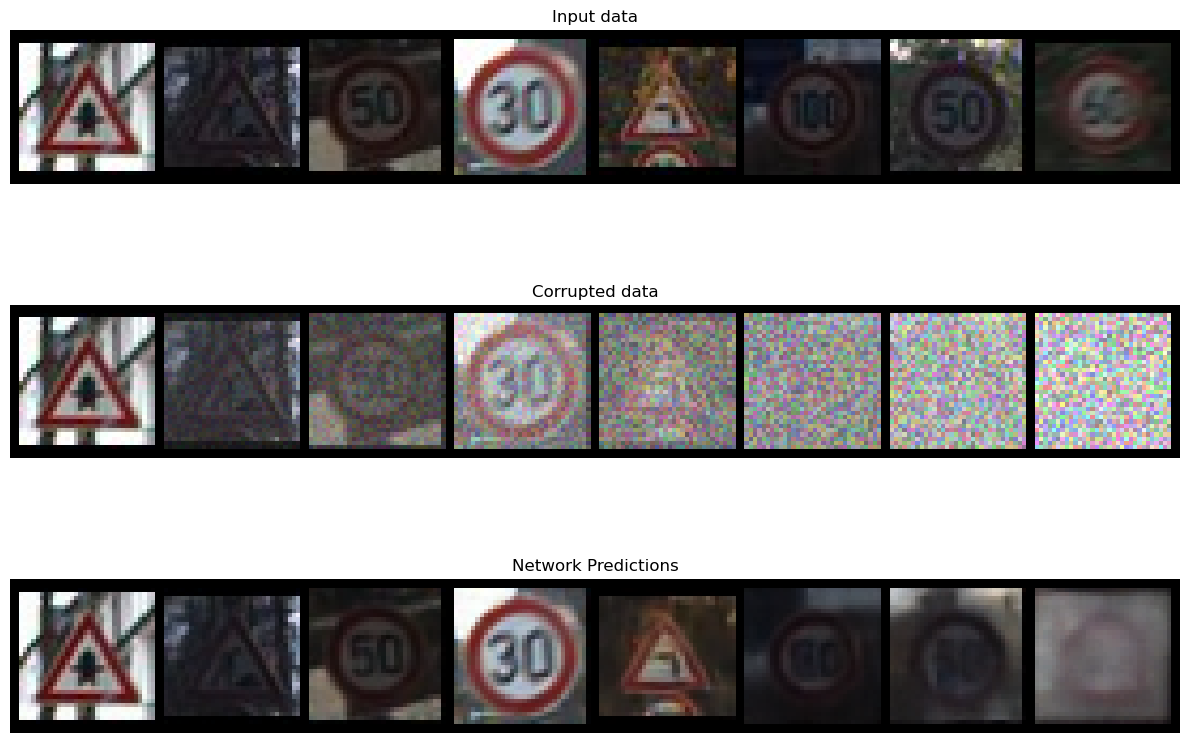

In [12]:
x, y = next(iter(train_loader))
x = x[:8]  # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0]).to(x.device)
amount_reshaped = amount[:, None, None, None]
noised_x = corrupt(x, amount_reshaped)

# Get the model predictions
with torch.no_grad():
    preds = net(noised_x.to(device), amount.to(device)).detach().cpu()

x = x / 2 + 0.5  # unnormalize
noised_x = noised_x / 2 + 0.5  # unnormalize
preds = preds / 2 + 0.5  # unnormalize

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 9))

# Helper function to handle RGB plotting
def show_rgb(tensor):
    grid = torchvision.utils.make_grid(tensor, nrow=8).permute(1, 2, 0).clip(0, 1)
    return grid

axs[0].set_title('Input data')
axs[0].imshow(show_rgb(x))
axs[0].axis('off')

axs[1].set_title('Corrupted data')
axs[1].imshow(show_rgb(noised_x))
axs[1].axis('off')

axs[2].set_title('Network Predictions')
axs[2].imshow(show_rgb(preds))
axs[2].axis('off')

plt.tight_layout()
plt.show()

(np.float64(-0.5), np.float64(273.5), np.float64(273.5), np.float64(-0.5))

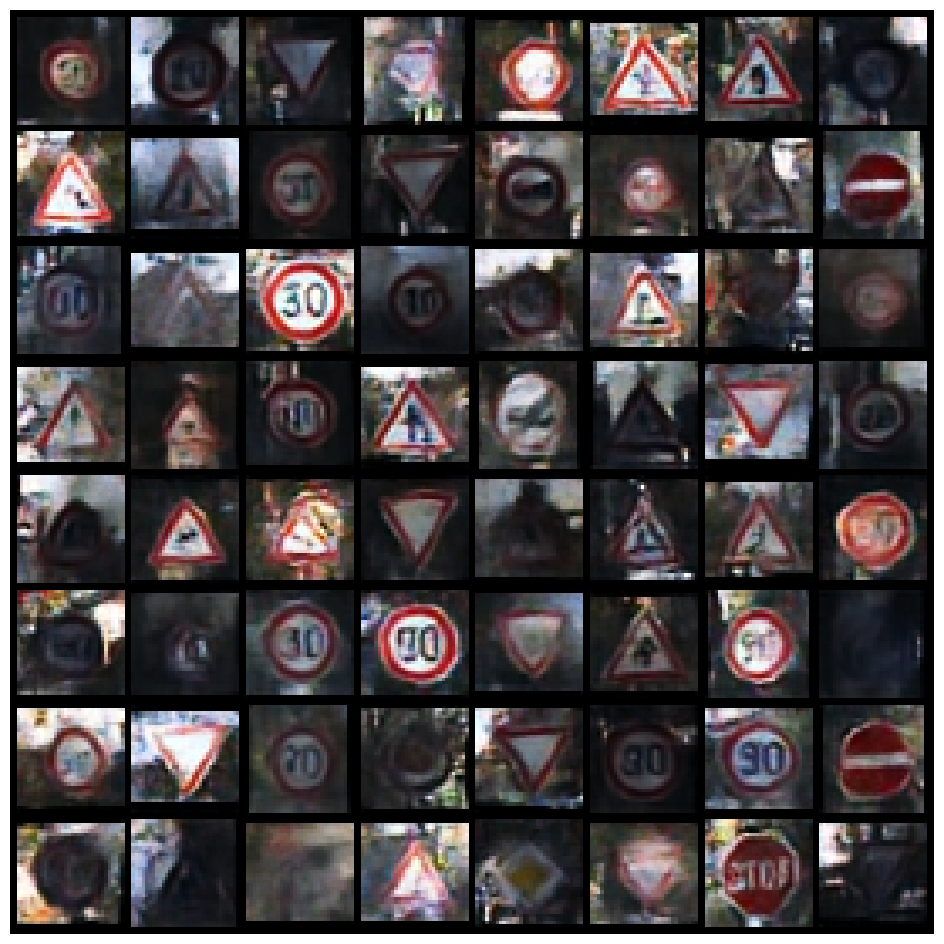

In [15]:
n_steps = 30
x = torch.rand(64, 3, 32, 32).to(device)

for i in range(n_steps):
  t = (torch.zeros(x.size(0)) + (n_steps - i)/n_steps).to(device)
  with torch.no_grad():
    pred = net(x, t)
    mix_factor = 1/(n_steps - i)
    x = x*(1-mix_factor) + pred*mix_factor
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

x = x / 2 + 0.5  # unnormalize

grid = torchvision.utils.make_grid(x.detach().cpu(), nrow=8)
ax.imshow(grid.permute(1, 2, 0).clip(0, 1))
ax.axis('off')

In [ ]:
import torch
import os

n_steps = 30
total_images = 1000

x = torch.rand(total_images, 3, 32, 32).to(device)

for i in range(n_steps):
    t = (torch.zeros(total_images) + (n_steps - i)/n_steps).to(device)
    with torch.no_grad():
        pred = net(x, t)
        mix_factor = 1/(n_steps - i)
        x = x*(1-mix_factor) + pred*mix_factor


generated_imgs = x.cpu().detach()

torch.save(generated_imgs, "sroda_cisek_wiecyk.pt")

In [ ]:
gen_folder = "generated_images"
os.makedirs(gen_folder, exist_ok=True)

for i in range(generated_imgs.size(0)):
    img = generated_imgs[i]
    if img.min() < 0 or img.max() > 1:
        img = img / 2 + 0.5
    torchvision.utils.save_image(img, f"{gen_folder}/{i:04d}.jpg", normalize=False)